In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8" 
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(2)
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Add, BatchNormalization, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ast

from tensorflow.keras.utils import to_categorical

In [4]:
df = pd.read_csv("combined_dataset.csv")
print(df.head())
df.info()
df.isnull().sum()


   age  ethnicity  gender                                             pixels
0   28          4       1  [164, 164, 164, 164, 163, 163, 163, 163, 164, ...
1    1          0       0  [223, 224, 224, 224, 224, 224, 224, 226, 224, ...
2    4          4       1  [182, 184, 185, 186, 188, 191, 194, 195, 197, ...
3   85          0       0  [25, 29, 126, 145, 36, 39, 46, 53, 57, 23, 38,...
4   75          1       0  [13, 14, 17, 18, 18, 19, 19, 19, 17, 62, 117, ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33840 entries, 0 to 33839
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        33840 non-null  int64 
 1   ethnicity  33840 non-null  int64 
 2   gender     33840 non-null  int64 
 3   pixels     33840 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.0+ MB


age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [5]:

# Load your combined dataset
df = pd.read_csv("combined_dataset.csv")

# Convert stringified lists into actual Python lists
df['pixels'] = df['pixels'].apply(ast.literal_eval)

# Now convert to numpy arrays
X = np.stack(df['pixels'].values).astype(np.uint8)
X = X.reshape(-1, 48, 48, 1)  # Add channel dimension for CNN

# Extract labels
y = df.drop(columns=["pixels"])

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)


✅ X shape: (33840, 48, 48, 1)
✅ y shape: (33840, 3)


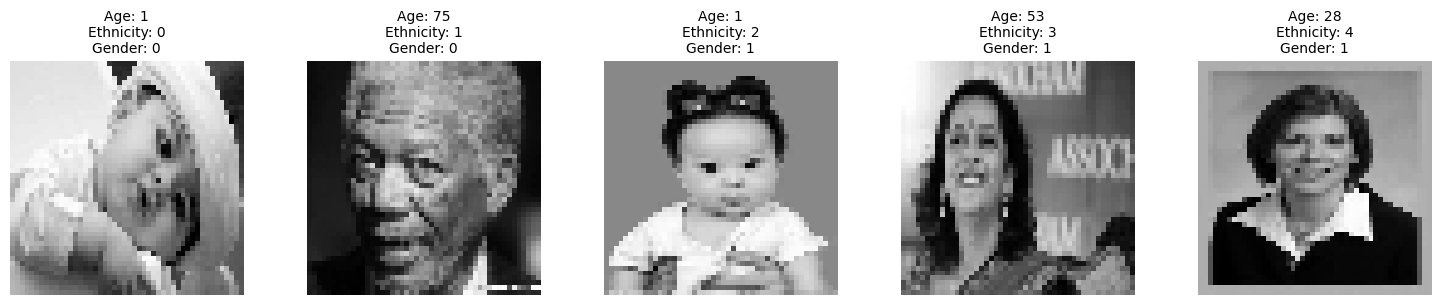

In [6]:
ethnicity_indices = []

for race in range(5):
    index = y[y['ethnicity'] == race].index[0]  # first match
    ethnicity_indices.append(index)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = ethnicity_indices[i]
    ax.imshow(X[idx].squeeze(), cmap='gray')
    ax.axis("off")
    ax.set_title(
        f"Age: {y['age'].iloc[idx]}\nEthnicity: {y['ethnicity'].iloc[idx]}\nGender: {y['gender'].iloc[idx]}",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [14]:
X = X / 255.0
ethnicity_matrix = np.array(y["ethnicity"])
num_classes = 5  # update if needed based on your dataset
ethnicity = to_categorical(ethnicity_matrix, num_classes=num_classes)

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, ethnicity, test_size=0.2, random_state=42, stratify=ethnicity_matrix
)


In [16]:
def ConvFunc(x, filters = 16, kernel_size = (3, 3),dropout_rate=0.1):
    x = Conv2D(filters, kernel_size = kernel_size, padding = "same",
              kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(momentum=0.95)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    return x


def create_ethnicity_model():
    inputs = Input(shape = (48, 48, 1))

    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)
    x = ConvFunc(x, 256, dropout_rate=0.25)

    x = Flatten()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    

    outputs = Dense(num_classes, activation="softmax")(x)

    
    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, epsilon=1e-7)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model
ethnicity_model = create_ethnicity_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)

    

In [36]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

ethnicity_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/50
423/423 [==============================] - 10s 22ms/step - loss: 2.6513 - accuracy: 0.4838 - val_loss: 2.3965 - val_accuracy: 0.5465 - lr: 3.0000e-04
Epoch 2/50
423/423 [==============================] - 9s 22ms/step - loss: 2.2660 - accuracy: 0.5464 - val_loss: 2.0383 - val_accuracy: 0.6067 - lr: 3.0000e-04
Epoch 3/50
423/423 [==============================] - 9s 22ms/step - loss: 1.9812 - accuracy: 0.5887 - val_loss: 1.8337 - val_accuracy: 0.6217 - lr: 3.0000e-04
Epoch 4/50
423/423 [==============================] - 9s 22ms/step - loss: 1.7635 - accuracy: 0.6186 - val_loss: 1.6279 - val_accuracy: 0.6399 - lr: 3.0000e-04
Epoch 5/50
423/423 [==============================] - 9s 22ms/step - loss: 1.6029 - accuracy: 0.6352 - val_loss: 1.5229 - val_accuracy: 0.6469 - lr: 3.0000e-04
Epoch 6/50
423/423 [==============================] - 9s 22ms/step - loss: 1.4847 - accuracy: 0.6430 - val_loss: 1.4010 - val_accuracy: 0.6729 - lr: 3.0000e-04
Epoch 7/50
423/423 [===================

In [37]:
ethnicity_model.save_weights("ethnicity_weights_2.h5")


In [38]:
ethnicity_model.evaluate(X_test, y_test)


212/212 [==============================] - 1s 4ms/step - loss: 0.8763 - accuracy: 0.7527


[0.8763214349746704, 0.7526595592498779]

In [17]:
print(df['age'].max())
age=df['age']


116


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, age, test_size=0.2, random_state=42
)

In [19]:
y_train = np.array(y_train).astype("float32")  
y_test = np.array(y_test).astype("float32")
y_train = y_train / 116
y_test = y_test / 116


In [20]:
print("Max y_train:", y_train.max())  
print("Min y_train:", y_train.min())  

Max y_train: 1.0
Min y_train: 0.00862069


In [21]:


def ConvBlock(x, filters, dropout_rate=0.1):
    x = Conv2D(filters, kernel_size=(3, 3), padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, kernel_size=(3, 3), padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    return x

def create_deep_age_model():
    inputs = Input(shape=(48, 48, 1))

    x = ConvBlock(inputs, 32, dropout_rate=0.1)
    x = ConvBlock(x, 64, dropout_rate=0.15)
    x = ConvBlock(x, 128, dropout_rate=0.2)
    x = ConvBlock(x, 256, dropout_rate=0.25)
    x = ConvBlock(x, 512, dropout_rate=0.3)  # 5th block for extra depth

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation="softplus")(x)  # Predicts positive age

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss=tf.keras.losses.Huber(delta=2.0),  # robust to outliers
        metrics=["mae"]
    )
    return model

age_model = create_deep_age_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=12, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=6, factor=0.5, verbose=1, min_lr=1e-5
)


In [11]:
age_model.fit(
    X_train, y_train,
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
212/212 [==============================] - 47s 204ms/step - loss: 3.9739 - mae: 0.2398 - val_loss: 3.2788 - val_mae: 0.1832 - lr: 2.0000e-04
Epoch 2/50
212/212 [==============================] - 42s 200ms/step - loss: 2.6884 - mae: 0.1593 - val_loss: 2.1652 - val_mae: 0.2182 - lr: 2.0000e-04
Epoch 3/50
212/212 [==============================] - 43s 204ms/step - loss: 1.7457 - mae: 0.1415 - val_loss: 1.4219 - val_mae: 0.2771 - lr: 2.0000e-04
Epoch 4/50
212/212 [==============================] - 43s 202ms/step - loss: 1.1283 - mae: 0.1292 - val_loss: 0.9437 - val_mae: 0.2958 - lr: 2.0000e-04
Epoch 5/50
212/212 [==============================] - 43s 202ms/step - loss: 0.7387 - mae: 0.1210 - val_loss: 0.6335 - val_mae: 0.2791 - lr: 2.0000e-04
Epoch 6/50
212/212 [==============================] - 43s 203ms/step - loss: 0.4941 - mae: 0.1141 - val_loss: 0.4322 - val_mae: 0.2463 - lr: 2.0000e-04
Epoch 7/50
212/212 [==============================] - 42s 200ms/step - loss: 0.3390 - ma

In [12]:
age_model.save_weights("age_weights_2.h5")


In [13]:
age_model.evaluate(X_test, y_test)


212/212 [==============================] - 4s 19ms/step - loss: 0.0090 - mae: 0.0764


[0.008968569338321686, 0.0763947144150734]

In [22]:
gender=df['gender']
print(gender)

0        1
1        0
2        1
3        0
4        0
        ..
33835    1
33836    1
33837    1
33838    1
33839    1
Name: gender, Length: 33840, dtype: int64


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, gender, test_size=0.2, random_state=42
)

In [24]:
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(filters, kernel_size=kernel_size, padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)
    return x
def create_gender_model():
    inputs = Input(shape=(48, 48, 1))

    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)


    x = Flatten()(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


gender_model = create_gender_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)

In [50]:
gender_model.fit(
    X_train, y_train, 
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/100
212/212 [==============================] - 8s 34ms/step - loss: 1.3033 - accuracy: 0.6315 - val_loss: 1.2058 - val_accuracy: 0.6782 - lr: 3.0000e-04
Epoch 2/100
212/212 [==============================] - 7s 33ms/step - loss: 1.0927 - accuracy: 0.7180 - val_loss: 0.9971 - val_accuracy: 0.7571 - lr: 3.0000e-04
Epoch 3/100
212/212 [==============================] - 7s 33ms/step - loss: 0.9532 - accuracy: 0.7606 - val_loss: 0.8665 - val_accuracy: 0.7886 - lr: 3.0000e-04
Epoch 4/100
212/212 [==============================] - 7s 32ms/step - loss: 0.8542 - accuracy: 0.7791 - val_loss: 0.7771 - val_accuracy: 0.8100 - lr: 3.0000e-04
Epoch 5/100
212/212 [==============================] - 7s 32ms/step - loss: 0.7746 - accuracy: 0.7933 - val_loss: 0.7282 - val_accuracy: 0.8057 - lr: 3.0000e-04
Epoch 6/100
212/212 [==============================] - 7s 32ms/step - loss: 0.7154 - accuracy: 0.7998 - val_loss: 0.6672 - val_accuracy: 0.8165 - lr: 3.0000e-04
Epoch 7/100
212/212 [=============

In [51]:
gender_model.save_weights('gender_weights_2.h5')

In [25]:
from PIL import Image
import numpy as np
import cv2

def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")  # Grayscale
    img = img.resize((48, 48))                 # Resize
    img = np.array(img).astype("float32") / 255.0
    img = img.reshape(1, 48, 48, 1)             # Add batch + channel dims
    return img

In [26]:
from tensorflow.keras.models import load_model

ethnicity_model = create_ethnicity_model() 
ethnicity_model.load_weights("ethnicity_weights_2.h5")
age_model=create_deep_age_model()
age_model.load_weights("age_weights_2.h5")
gender_model = create_gender_model()
gender_model.load_weights("gender_weights_2.h5")

In [27]:
def predict_all(image_path):
    img = preprocess_image(image_path)

    predicted_age = age_model.predict(img)[0][0]
    predicted_age = predicted_age * 116
    predicted_gender_prob = gender_model.predict(img)[0][0]
    gender_label = "Female" if predicted_gender_prob > 0.5 else "Male"
    predicted_ethnicity = np.argmax(ethnicity_model.predict(img), axis=1)[0]
    ethnicity_labels = ["White", "Black", "Asian", "Indian", "Other"]
    ethnicity_label = ethnicity_labels[predicted_ethnicity]

    return predicted_age, gender_label, ethnicity_label


In [32]:
age, gender, ethnicity = predict_all("testimage1.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 16ms/step
Predicted Age: 32.0 years
Predicted Gender: Male
Predicted Ethnicity: White


In [33]:
age, gender, ethnicity = predict_all("testimage2.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 16ms/step
Predicted Age: 32.0 years
Predicted Gender: Male
Predicted Ethnicity: Asian


In [34]:
age, gender, ethnicity = predict_all("testimage3.jpeg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 15ms/step
Predicted Age: 31.9 years
Predicted Gender: Female
Predicted Ethnicity: Indian


In [36]:
age, gender, ethnicity = predict_all("testimage4.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 15ms/step
Predicted Age: 31.9 years
Predicted Gender: Male
Predicted Ethnicity: Indian


In [37]:
age, gender, ethnicity = predict_all("testimage5.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 15ms/step
Predicted Age: 31.9 years
Predicted Gender: Female
Predicted Ethnicity: White
